# 01 — Data Exploration

This notebook performs exploratory data analysis (EDA) for the project:
- Load site-level FLUXNET daily datasets and combine into one table
- Inspect structure, missingness, distributions, and correlations
- Engineer candidate features for downstream modeling
- Save a processed dataset for later notebooks

## 0. Set path

In [ ]:
# --- Mount Google Drive and point ROOT at your repo on Drive ---
from google.colab import drive
drive.mount('/content/drive')

In [28]:
from pathlib import Path

# Start from repo root or notebooks/ — both will resolve correctly
ROOT = Path("/content/drive/MyDrive/GitHub/machine-learning-final-project/")

DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
RESULTS = ROOT / "results"

# Make sure folders exist
for d in (DATA_RAW, DATA_PROCESSED, RESULTS):
    d.mkdir(parents=True, exist_ok=True)

print("Raw data folder:", DATA_RAW)
print("Processed data folder:", DATA_PROCESSED)
print("Results folder:", RESULTS)

Raw data folder: /content/drive/MyDrive/GitHub/machine-learning-final-project/data/raw
Processed data folder: /content/drive/MyDrive/GitHub/machine-learning-final-project/data/processed
Results folder: /content/drive/MyDrive/GitHub/machine-learning-final-project/results


## 1. Data sources and loading

I used daily ecosystem flux data sets, from the FLUXNET2015 database.

I decided to combine datasets from six different FLUXNET sites:

• US-Var (Vaira Ranch — grassland ecosystem)

• US-Ton (Tonzi Ranch — oak savanna)

• US-MMS (Morgan Monroe State Forest — deciduous broadleaf forest)

• US-Kon (Konza Prairie — native tallgrass prairie)

• US-UMB (University of Michigan Biological Station — mixed forest)

• US-Ha1 (Harvard Forest EMS — deciduous forest)

First step is to join them into one cohesive dataset for unified preprocessing and modeling.

In [29]:
import pandas as pd
import numpy as np
import glob

### ------------------ Concate the complete dataframe -----------------------###

# Define files and corresponding site names
site_files = {
    "US-Var": DATA_RAW / "AMF_US-Var_FLUXNET_SUBSET_DD_2000-2021_3-5.csv",
    "US-UMB": DATA_RAW / "AMF_US-UMB_FLUXNET_SUBSET_DD_2007-2021_3-5.csv",
    "US-Ton": DATA_RAW / "AMF_US-Ton_FLUXNET_SUBSET_DD_2001-2023_4-6.csv",
    "US-MMS": DATA_RAW / "AMF_US-MMS_FLUXNET_SUBSET_DD_1999-2020_3-5.csv",
    "US-Kon": DATA_RAW / "AMF_US-Kon_FLUXNET_SUBSET_DD_2004-2019_4-6.csv",
    "US-Ha1": DATA_RAW / "AMF_US-Ha1_FLUXNET_SUBSET_DD_1991-2020_3-5.csv"
}


# Define target and predictors
target = "GPP_NT_VUT_REF"
predictors = [
    "TA_F",        # Air temperature
    "VPD_F",       # Vapor pressure deficit
    "SW_IN_F",     # Shortwave radiation
    "PA_F",        # Air pressure
    "P_F",         # Precipitation
    "WS_F",        # Wind speed
    "LE_F_MDS",    # Latent heat flux
    "H_F_MDS",     # Sensible heat flux
    "PPFD_IN",     # Photosynthetic photon flux density
    "NETRAD"       # Net radiation
]

# Select columns
columns = ["TIMESTAMP", target] + predictors

# Load, label, and clean all data
dataframes = []
for site, filename in site_files.items():
    df = pd.read_csv(filename)
    df.replace(-9999, np.nan, inplace=True)
    df = df[columns].copy()
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d", errors="coerce")
    df["site"] = site
    df.dropna(subset=[target] + predictors, inplace=True)
    dataframes.append(df)


# Concatenate all into one dataframe
df_all = pd.concat(dataframes, ignore_index=True)
df_all = df_all[["site", "TIMESTAMP", target] + predictors]

print(f"Combined dataset shape: {df_all.shape}")
print("Sample rows:")
print(df_all.head())

# Save to CSV
out_path = DATA_PROCESSED / "combined_GPP_daily_FLUXNET.csv"
df_all.to_csv(out_path, index=False)
print("Saved processed dataset to:", out_path)


Combined dataset shape: (35447, 13)
Sample rows:
     site  TIMESTAMP  GPP_NT_VUT_REF    TA_F   VPD_F  SW_IN_F    PA_F    P_F  \
0  US-Var 2000-10-23         2.62240  15.701  13.275  144.241  99.323   0.00   
1  US-Var 2000-10-24         2.91881  17.417  13.553  145.474  99.766   0.00   
2  US-Var 2000-10-25         2.34361  12.739   3.778  151.173  99.274   9.40   
3  US-Var 2000-10-26         2.53444  11.951   1.259  145.879  98.674  12.71   
4  US-Var 2000-10-27         2.73883  13.275   0.054  143.659  98.925   0.25   

    WS_F  LE_F_MDS  H_F_MDS     PPFD_IN     NETRAD  
0  1.491   36.6987  15.8514  320.536437  31.407500  
1  1.271   35.0201  15.1848  323.274771  32.938333  
2  1.507   27.9223  19.6019  335.939979 -17.709167  
3  1.061   24.5069  17.9867  324.175317  -6.443104  
4  1.038   26.5328  19.5727  319.243033  43.107917  
Saved processed dataset to: /content/drive/MyDrive/GitHub/machine-learning-final-project/data/processed/combined_GPP_daily_FLUXNET.csv


### 2. Cleaning and Quality Checks

Initial inspection revealed that the variable `G_F_MDS` (ground heat flux) was entirely missing for the sites US-UMB and US-Ha1.  
To retain all six sites in the analysis, this predictor was excluded from the feature set.  
The remaining variables (`TA_F`, `VPD_F`, `SW_IN_F`, `PA_F`, `P_F`, `WS_F`, `LE_F_MDS`, `H_F_MDS`, `PPFD_IN`, `NETRAD`) were retained.  
After replacing `-9999` with `NaN` and dropping incomplete rows, the combined dataset includes **35,447 records** from all six sites.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# === Load the Combined Data Set ===
df_all = pd.read_csv(DATA_PROCESSED / "combined_GPP_daily_FLUXNET.csv")

# datset shape and preview
print(f"Combined dataset shape: {df_all.shape}")
print("Sample rows:")
print(df_all.head())

# Descriptive statistics
descriptives = df_all.describe().T.round(2)
print("\n📈 Descriptive statistics:")
display(descriptives)

# Row counts per site
site_counts = df_all["site"].value_counts().rename_axis("site").reset_index(name="row_count")
print("\n📍 Number of records per site:")
display(site_counts)

# === Data Types, Missing Values, and Overview ===
print("\nData types:\n", df_all.dtypes)
print("\nMissing values per column:\n", df_all.isnull().sum())
print("\nUnique sites:", df_all['site'].nunique())



Combined dataset shape: (35447, 13)
Sample rows:
     site   TIMESTAMP  GPP_NT_VUT_REF    TA_F   VPD_F  SW_IN_F    PA_F    P_F  \
0  US-Var  2000-10-23         2.62240  15.701  13.275  144.241  99.323   0.00   
1  US-Var  2000-10-24         2.91881  17.417  13.553  145.474  99.766   0.00   
2  US-Var  2000-10-25         2.34361  12.739   3.778  151.173  99.274   9.40   
3  US-Var  2000-10-26         2.53444  11.951   1.259  145.879  98.674  12.71   
4  US-Var  2000-10-27         2.73883  13.275   0.054  143.659  98.925   0.25   

    WS_F  LE_F_MDS  H_F_MDS     PPFD_IN     NETRAD  
0  1.491   36.6987  15.8514  320.536437  31.407500  
1  1.271   35.0201  15.1848  323.274771  32.938333  
2  1.507   27.9223  19.6019  335.939979 -17.709167  
3  1.061   24.5069  17.9867  324.175317  -6.443104  
4  1.038   26.5328  19.5727  319.243033  43.107917  

📈 Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
GPP_NT_VUT_REF,35447.0,3.52,4.43,-13.26,0.15,1.60,6.02,22.66
TA_F,35447.0,12.64,9.89,-21.88,6.43,13.73,20.38,36.61
VPD_F,35447.0,7.49,7.40,0.00,2.14,5.12,10.05,52.50
SW_IN_F,35447.0,187.92,105.85,2.44,97.87,182.17,282.02,482.91
PA_F,35447.0,98.70,0.95,94.15,98.26,98.86,99.28,101.74
P_F,35447.0,2.19,6.64,0.00,0.00,0.00,0.40,148.38
WS_F,35447.0,2.57,1.27,0.39,1.65,2.22,3.23,11.67
LE_F_MDS,35447.0,34.58,37.37,-22.89,6.82,19.32,53.08,252.65
H_F_MDS,35447.0,38.99,42.95,-94.15,8.18,28.30,64.16,527.58
PPFD_IN,35447.0,392.41,226.38,0.00,199.92,375.50,585.59,1166.79



📍 Number of records per site:


,site,row_count
0,US-Ha1,8066
1,US-Ton,8027
2,US-Var,6370
3,US-MMS,5284
4,US-UMB,4991
5,US-Kon,2709



Data types:
 site               object
TIMESTAMP          object
GPP_NT_VUT_REF    float64
TA_F              float64
VPD_F             float64
SW_IN_F           float64
PA_F              float64
P_F               float64
WS_F              float64
LE_F_MDS          float64
H_F_MDS           float64
PPFD_IN           float64
NETRAD            float64
dtype: object

Missing values per column:
 site              0
TIMESTAMP         0
GPP_NT_VUT_REF    0
TA_F              0
VPD_F             0
SW_IN_F           0
PA_F              0
P_F               0
WS_F              0
LE_F_MDS          0
H_F_MDS           0
PPFD_IN           0
NETRAD            0
dtype: int64

Unique sites: 6


### 3. Correlation Analysis

A correlation heatmap was created to assess relationships between predictors and the target variable (`GPP_NT_VUT_REF`).  
`SW_IN_F` (shortwave radiation) was found to be highly collinear with other radiation-related variables (`PPFD_IN`, `NETRAD`).  
To reduce multicollinearity and simplify the feature set, `SW_IN_F` was excluded from the predictors.  
The refined predictor set was used for all further modeling steps.


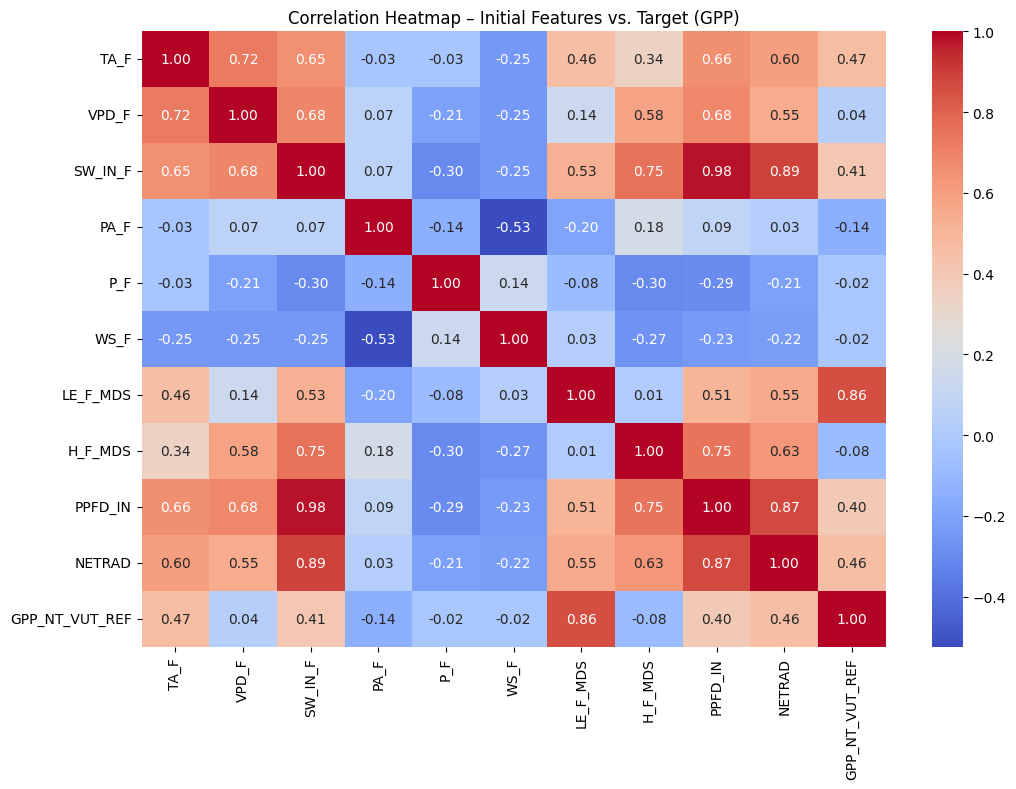

Removed SW_IN_F due to high collinearity.


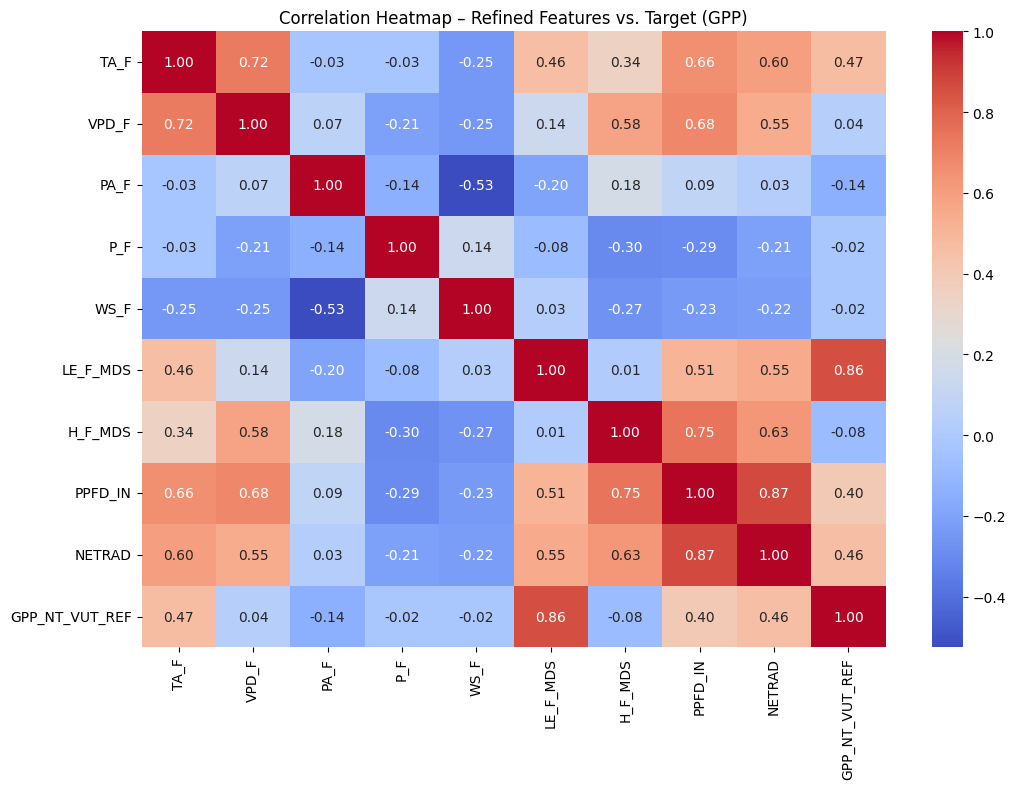

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initial correlation matrix (predictors + target)
corr_initial = df_all[predictors + [target]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_initial, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap – Initial Features vs. Target (GPP)")
plt.show()

# Drop highly collinear feature (SW_IN_F is strongly correlated with PPFD_IN/NETRAD)
if "SW_IN_F" in predictors:
    predictors.remove("SW_IN_F")
    print("Removed SW_IN_F due to high collinearity.")

# Recalculate correlation matrix after feature removal
corr_refined = df_all[predictors + [target]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_refined, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap – Refined Features vs. Target (GPP)")
plt.show()



### 4. Visual Patterns

Histograms and boxplots were used to visualize the distributions of predictor variables and the target across sites.  
- Histograms illustrate the overall range and skewness of each predictor.  
- Boxplots by site highlight differences in distributions and detect potential outliers.  
- A boxplot of gross primary productivity (GPP) by site reveals site-level variability in the target variable.  

All figures were saved to the `results/` folder for later reference.


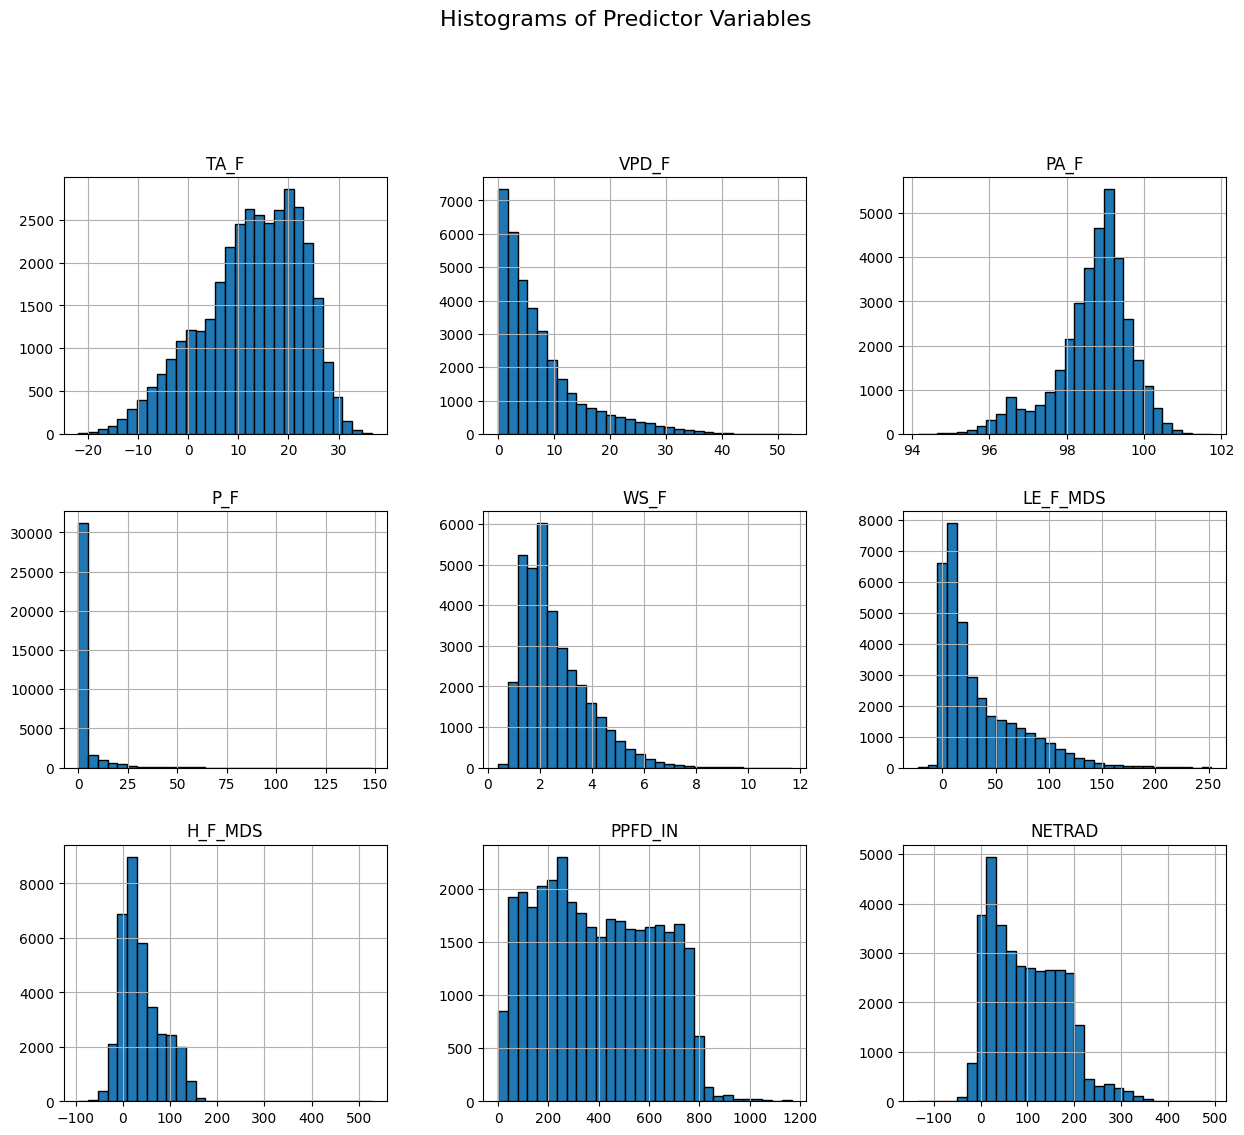

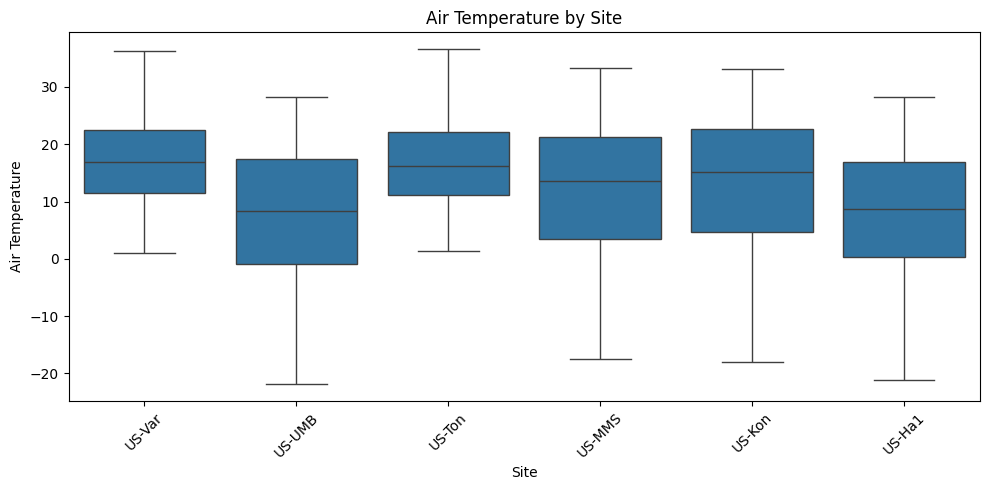

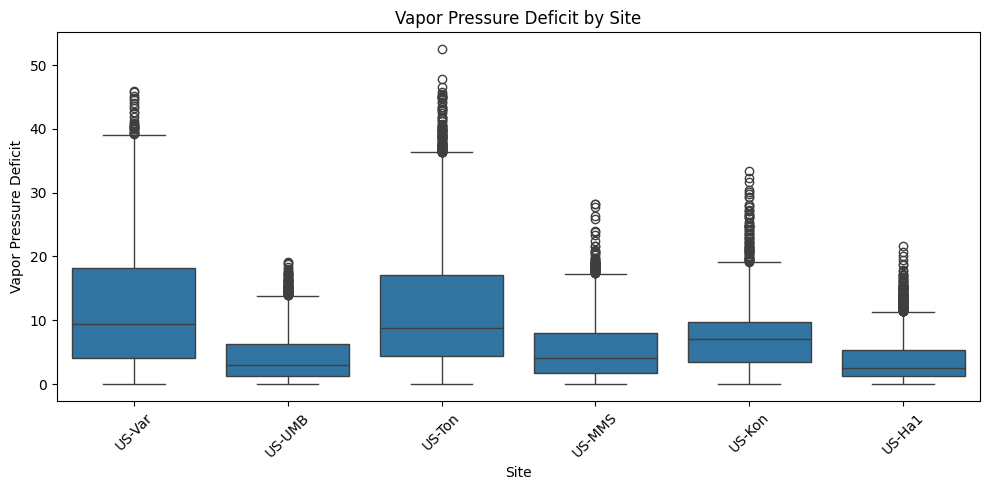

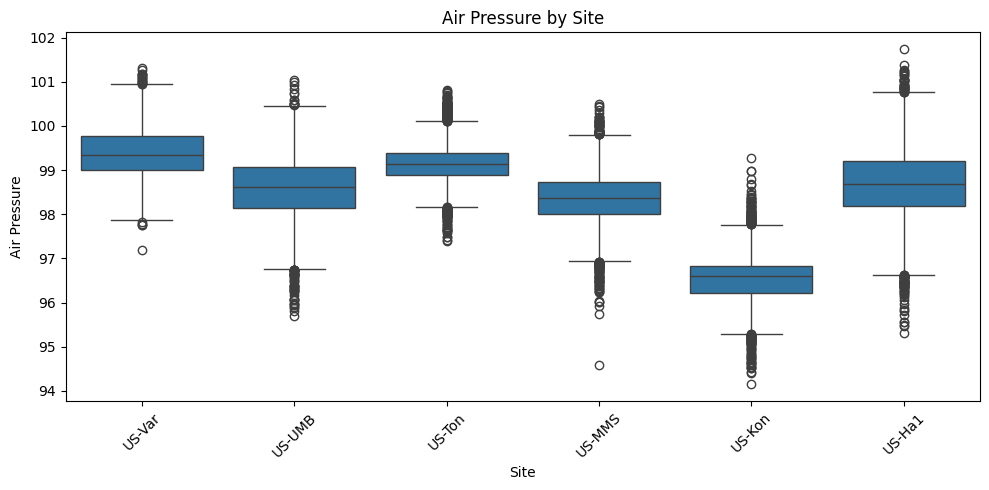

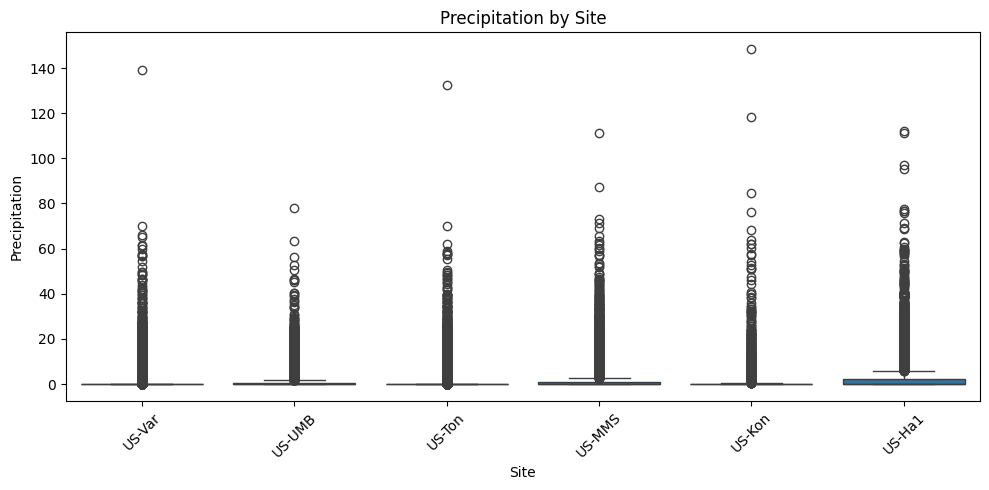

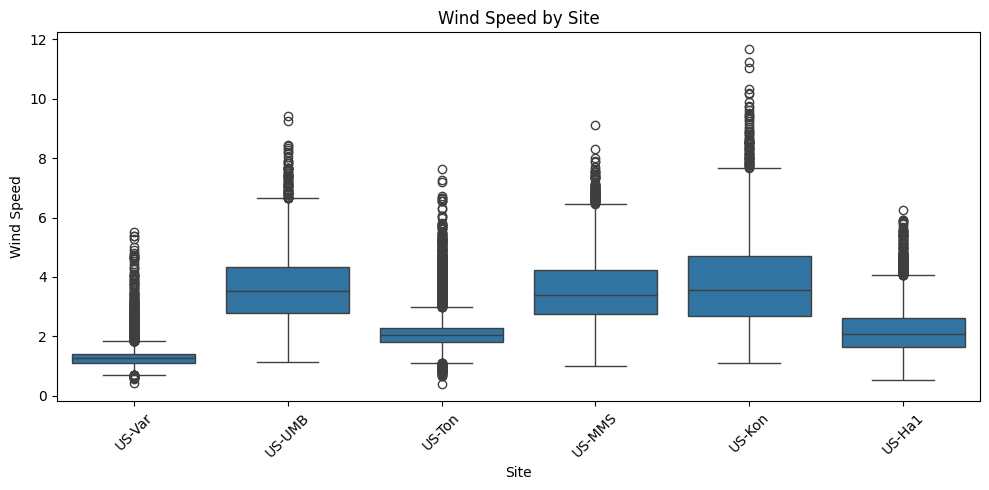

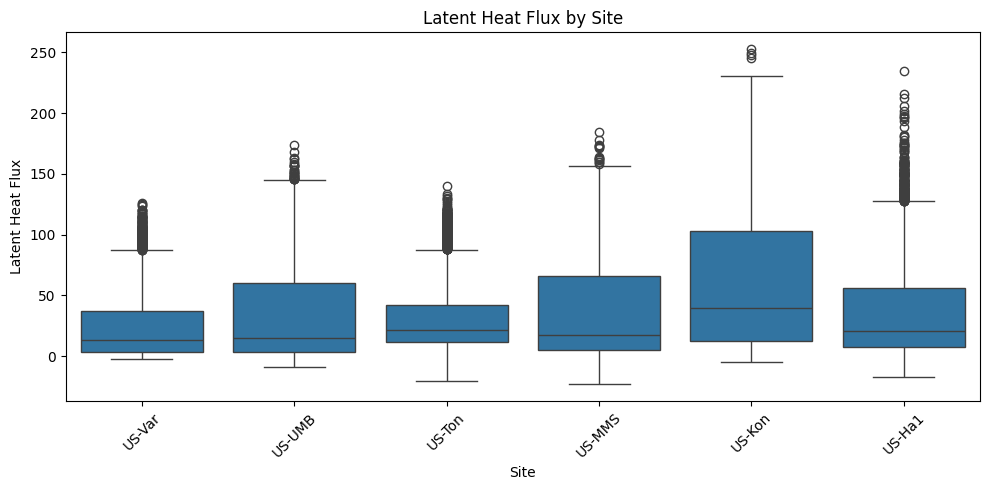

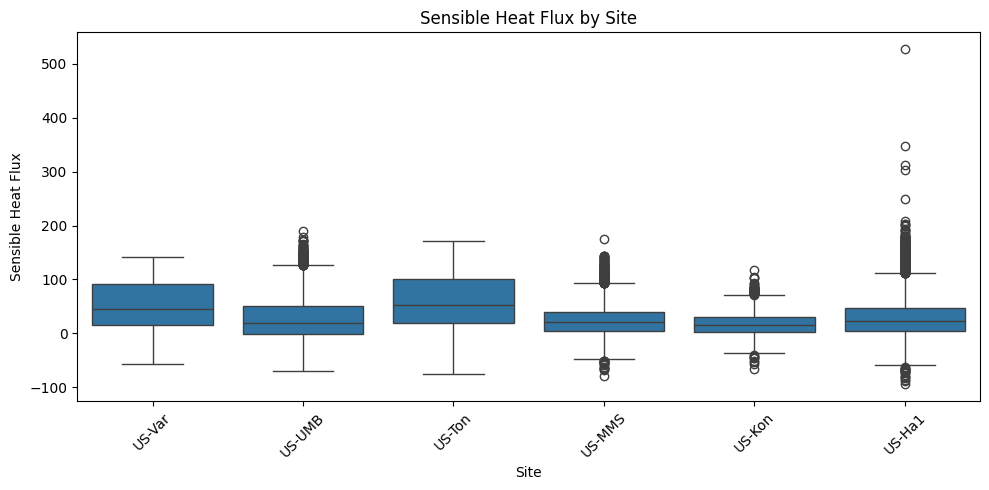

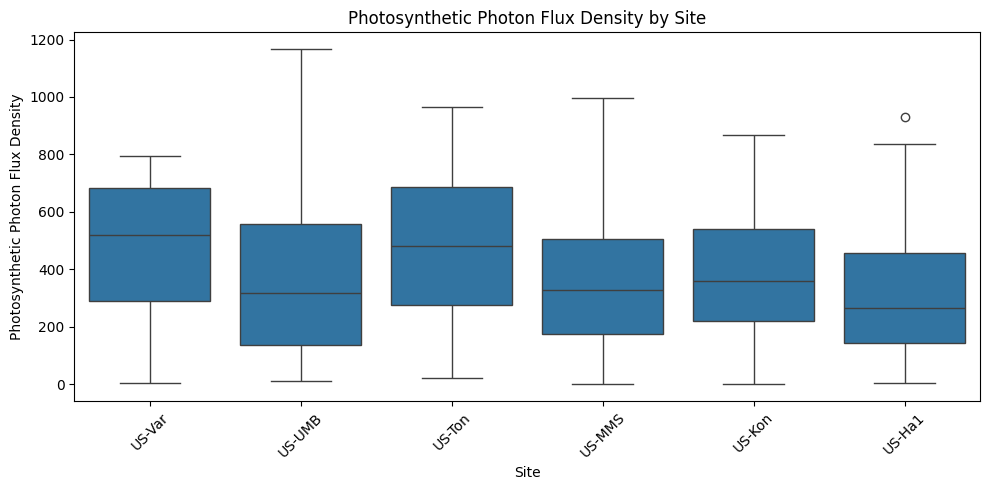

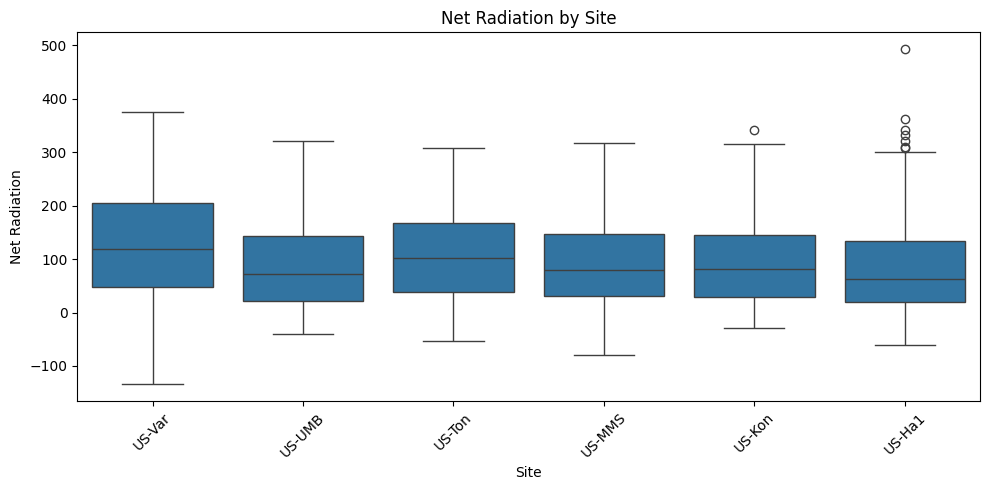

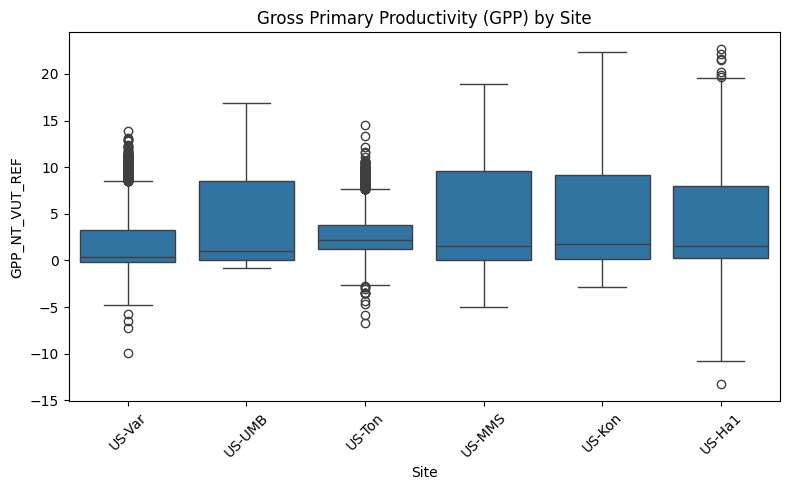

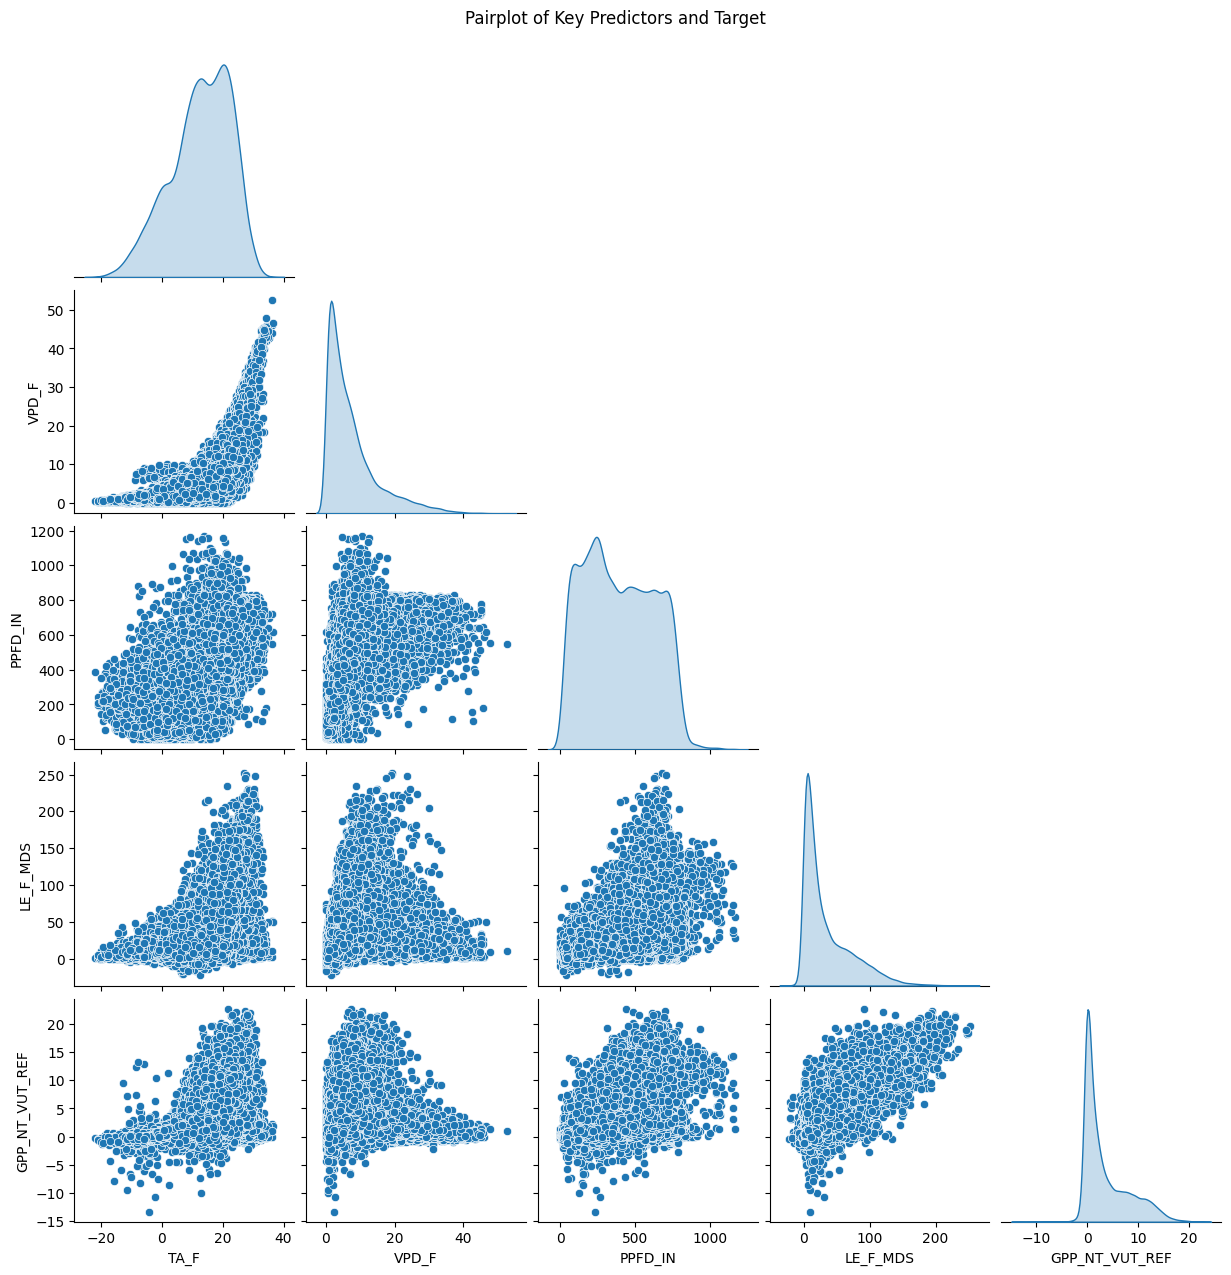

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature names for prettier plot titles
feature_names = {
    "GPP_NT_VUT_REF": "Gross Primary Productivity",
    "TA_F": "Air Temperature",
    "VPD_F": "Vapor Pressure Deficit",
    "PPFD_IN": "Photosynthetic Photon Flux Density",
    "PA_F": "Air Pressure",
    "P_F": "Precipitation",
    "WS_F": "Wind Speed",
    "LE_F_MDS": "Latent Heat Flux",
    "H_F_MDS": "Sensible Heat Flux",
    "NETRAD": "Net Radiation"
}

# === 1. Histograms of predictors ===
ax = df_all[predictors].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of Predictor Variables", fontsize=16, y=1.02)
plt.savefig(RESULTS / "histograms_predictors.png", dpi=150, bbox_inches="tight")
plt.show()

# === 2. Boxplots of predictors by site ===
for feature in predictors:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="site", y=feature, data=df_all)
    title = feature_names.get(feature, feature)
    plt.title(f"{title} by Site")
    plt.xlabel("Site")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(RESULTS / f"boxplot_{feature}.png", dpi=150, bbox_inches="tight")
    plt.show()

# === 3. Boxplot of GPP by site ===
plt.figure(figsize=(8, 5))
sns.boxplot(x="site", y=target, data=df_all)
plt.title("Gross Primary Productivity (GPP) by Site")
plt.xlabel("Site")
plt.ylabel("GPP_NT_VUT_REF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS / "boxplot_gpp_by_site.png", dpi=150, bbox_inches="tight")
plt.show()

# === 4. Pairplots (scatter matrix) for a subset of predictors  ===
subset_features = ["TA_F", "VPD_F", "PPFD_IN", "LE_F_MDS", target]
sns.pairplot(df_all[subset_features], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Key Predictors and Target", y=1.02)
plt.savefig(RESULTS / "pairplot_subset.png", dpi=150, bbox_inches="tight")
plt.show()



### 5. Feature Engineering

Several additional features were created to capture non-linear and temporal dynamics:

- `TEMP_X_VPD` = interaction between air temperature and vapor pressure deficit  
- `RADIATION_BALANCE` = combined measure of net radiation and photon flux density  
- `GPP_LAG1` = one-day lag of gross primary productivity  
- `GPP_DIFF` = day-to-day change in gross primary productivity  
- `GPP_VAR7` = seven-day rolling variance of gross primary productivity  

These features enhance the predictor set by representing combined environmental stress, energy balance, and short-term temporal trends.  
All features were standardized (mean = 0, std = 1) for use in subsequent modeling.



Missing values per column:
 site                 0
TIMESTAMP            0
GPP_NT_VUT_REF       0
TA_F                 0
VPD_F                0
SW_IN_F              0
PA_F                 0
P_F                  0
WS_F                 0
LE_F_MDS             0
H_F_MDS              0
PPFD_IN              0
NETRAD               0
TEMP_X_VPD           0
RADIATION_BALANCE    0
GPP_LAG1             0
GPP_DIFF             0
GPP_VAR7             0
dtype: int64

Correlation with GPP (including engineered features):

GPP_NT_VUT_REF       1.00
GPP_LAG1             0.94
LE_F_MDS             0.86
GPP_VAR7             0.50
TA_F                 0.47
NETRAD               0.46
RADIATION_BALANCE    0.43
PPFD_IN              0.40
GPP_DIFF             0.17
TEMP_X_VPD           0.05
VPD_F                0.03
WS_F                -0.02
P_F                 -0.02
H_F_MDS             -0.08
PA_F                -0.14
Name: GPP_NT_VUT_REF, dtype: float64


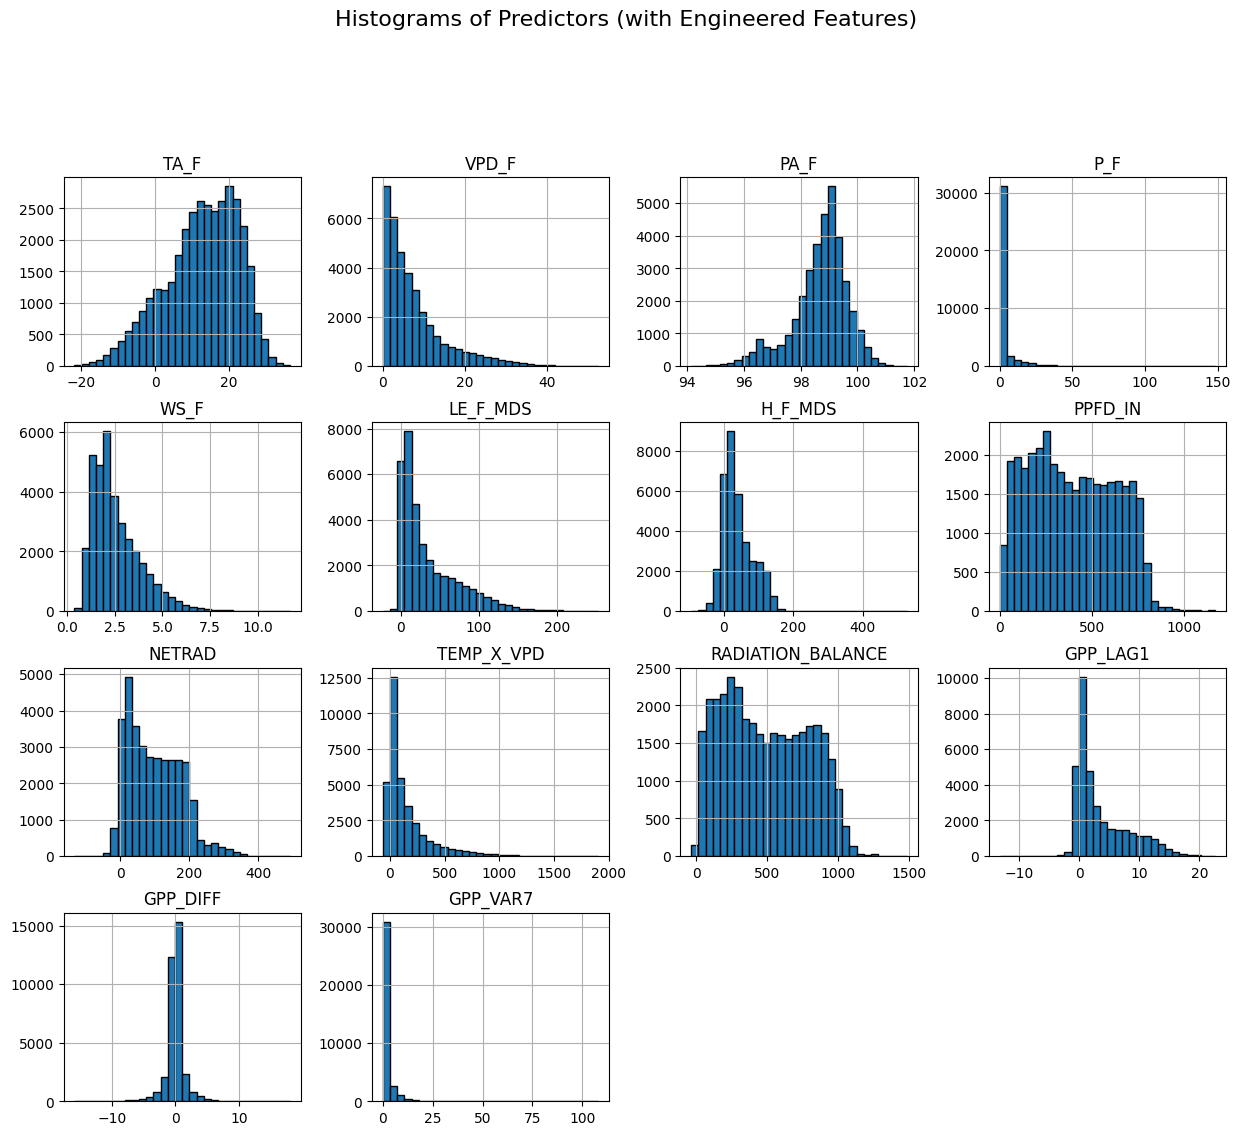


Correlation of Standardized Predictors with GPP (incl. engineered features):

GPP_NT_VUT_REF       1.00
GPP_LAG1             0.94
LE_F_MDS             0.86
GPP_VAR7             0.50
TA_F                 0.47
NETRAD               0.46
RADIATION_BALANCE    0.43
PPFD_IN              0.40
GPP_DIFF             0.17
TEMP_X_VPD           0.05
VPD_F                0.03
WS_F                -0.02
P_F                 -0.02
H_F_MDS             -0.08
PA_F                -0.14
Name: GPP_NT_VUT_REF, dtype: float64


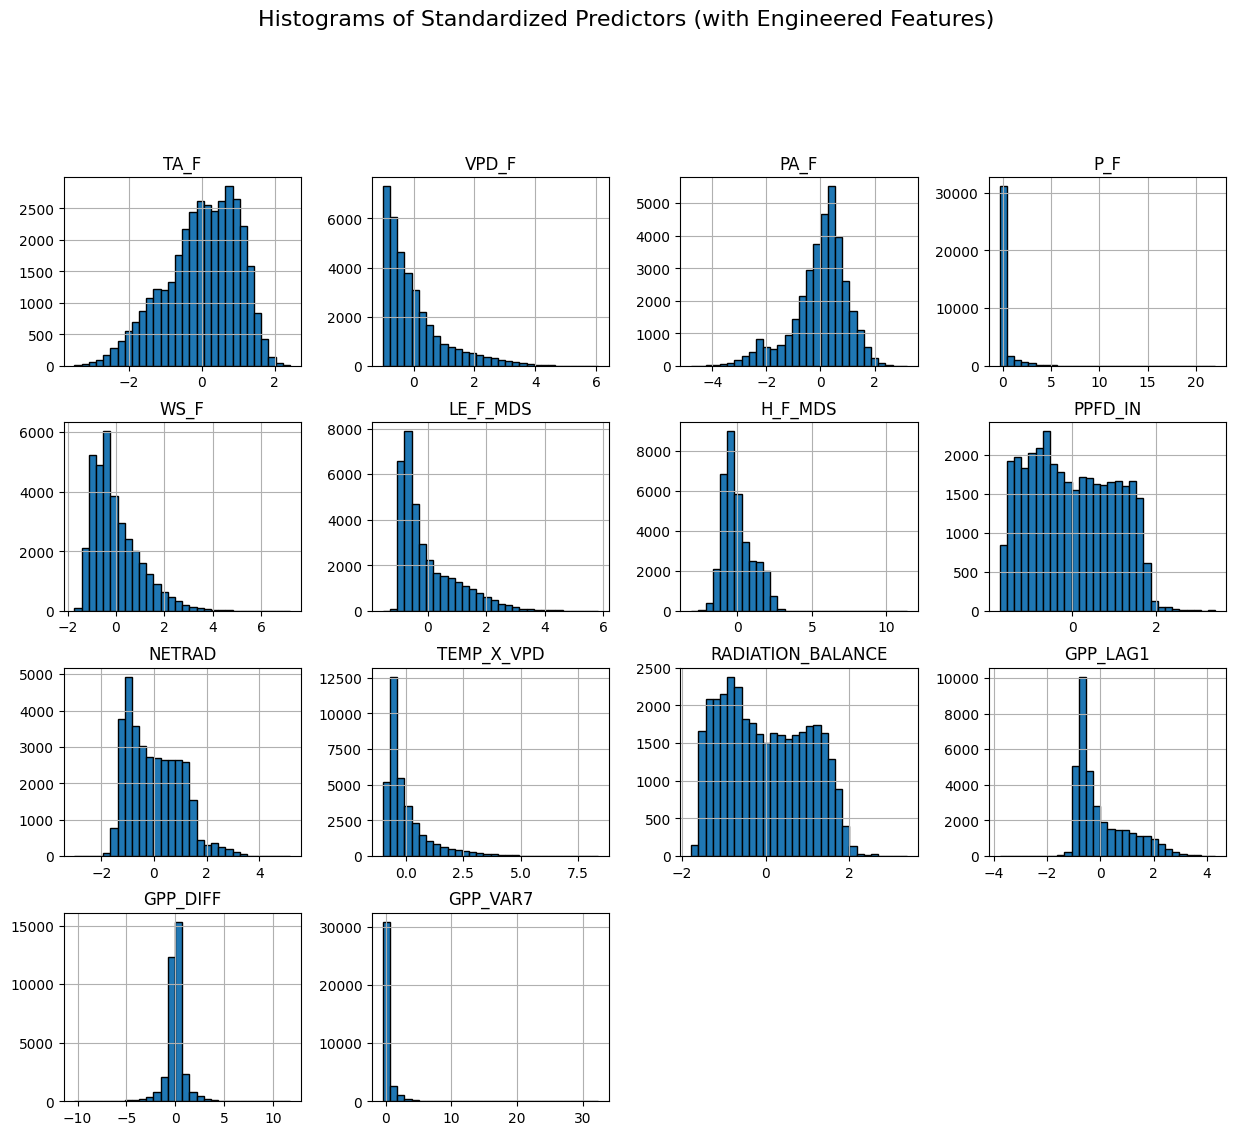

In [33]:
from sklearn.preprocessing import StandardScaler

# 1) Interaction term: temperature × VPD
if "TEMP_X_VPD" not in df_all.columns:
    df_all["TEMP_X_VPD"] = df_all["TA_F"] * df_all["VPD_F"]

# 2) Radiation balance (redefined without G_F_MDS)
if "RADIATION_BALANCE" not in df_all.columns:
    df_all["RADIATION_BALANCE"] = df_all["NETRAD"] + df_all["PPFD_IN"]

# Update predictors
for col in ["TEMP_X_VPD", "RADIATION_BALANCE"]:
    if col not in predictors:
        predictors.append(col)

# 3) Temporal features per site
df_all = df_all.sort_values(["site", "TIMESTAMP"])

if "GPP_LAG1" not in df_all.columns:
    df_all["GPP_LAG1"] = df_all.groupby("site")[target].shift(1)

if "GPP_DIFF" not in df_all.columns:
    df_all["GPP_DIFF"] = df_all[target] - df_all["GPP_LAG1"]

if "GPP_VAR7" not in df_all.columns:
    df_all["GPP_VAR7"] = (
        df_all.groupby("site")[target].rolling(window=7).var().reset_index(0, drop=True)
    )

# Drop rows with missing values from shifting/rolling
df_all.dropna(subset=["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"], inplace=True)

print("\nMissing values per column:\n", df_all.isnull().sum())

# Add new features to predictors list
for col in ["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]:
    if col not in predictors:
        predictors.append(col)

# 4) Correlation with engineered features
corr_new = df_all[predictors + [target]].corr()
print("\nCorrelation with GPP (including engineered features):\n")
print(corr_new[target].sort_values(ascending=False).round(2))

# Histograms (raw features, incl. engineered)
df_all[predictors].hist(bins=30, figsize=(15, 12), edgecolor="black")
plt.suptitle("Histograms of Predictors (with Engineered Features)", fontsize=16, y=1.02)
plt.savefig(RESULTS / "histograms_predictors_engineered.png", dpi=150, bbox_inches="tight")
plt.show()

# 5) Scale all predictors
scaler = StandardScaler()
df_scaled = df_all.copy()
df_scaled[predictors] = scaler.fit_transform(df_all[predictors])

# Correlation of standardized predictors with target
corr_std = df_scaled[predictors + [target]].corr()
print("\nCorrelation of Standardized Predictors with GPP (incl. engineered features):\n")
print(corr_std[target].sort_values(ascending=False).round(2))

# Histograms (standardized)
df_scaled[predictors].hist(bins=30, figsize=(15, 12), edgecolor="black")
plt.suptitle("Histograms of Standardized Predictors (with Engineered Features)", fontsize=16, y=1.02)
plt.savefig(RESULTS / "histograms_standardized_predictors.png", dpi=150, bbox_inches="tight")
plt.show()


### 6. Save processed dataset

In [34]:
# === Save final datasets ===
processed_path = DATA_PROCESSED / "df_processed.csv"
scaled_path = DATA_PROCESSED / "df_scaled.csv"

df_all.to_csv(processed_path, index=False)
df_scaled.to_csv(scaled_path, index=False)

print("Saved:", processed_path, "and", scaled_path)


Saved: /content/drive/MyDrive/GitHub/machine-learning-final-project/data/processed/df_processed.csv and /content/drive/MyDrive/GitHub/machine-learning-final-project/data/processed/df_scaled.csv
